In [1]:
import logging
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from pathlib import Path
from utils import tools
from modules.cae_base_module import CAEBaseModule
from models import supported_models
from datasets import supported_datamodules

print(Path.cwd())

/home/brahste/Projects/novelty-detection/experiments


In [2]:
# Import configurations and paths to logged models
root = Path.cwd() / '..'
log_path = root / 'logs' / 'NoveltyMNISTDataModule'
paths_to_archived_models = Path(log_path).glob('**/archive*')

module_catalog = {}

for pth in paths_to_archived_models:
    config = tools.load_config(pth / 'configuration.yaml', silent=True)
    model_type = pth.parent.name
    model_name = pth.name
    model_path = next(iter((pth / 'checkpoints').glob('val_loss*')))
    
    datamodule = supported_datamodules[config['experiment-parameters']['datamodule']](
        **config['data-parameters'])
    datamodule.setup('test')

    model = supported_models[config['experiment-parameters']['model']](
        in_chans=datamodule.data_shape[0])

    module = CAEBaseModule(model, **config['module-parameters'])
    
    # Load the state_dict into the module architecture
    checkpoint = torch.load(model_path)
    module.load_state_dict(checkpoint['state_dict'])
    
    if model_type not in module_catalog:
        module_catalog[model_type] = {}
    module_catalog[model_type][model_name] = module

In [3]:
import pandas as pd

scores = pd.DataFrame()
labels = pd.DataFrame()
for model_type, model_variants in module_catalog.items():
    for model_name, module in model_variants.items():
        test_novelty_scores = []
        test_novelty_labels = []
        short_name = model_type + '-' + model_name.split('_')[1]
        print(f'{short_name}\n-----')
        module.model.eval()  # Freeze dropout and batch normalization parameters
        with torch.no_grad():
            for batch_nb, batch in enumerate(datamodule.test_dataloader()):
                result = module.test_step(batch, batch_nb)

                test_novelty_scores.extend(result['scores'].cpu().numpy())
                test_novelty_labels.extend(result['labels'].cpu().numpy())
                print(f'[BATCH {batch_nb}] Mean score: {result["scores"].mean()}')
            scores.loc[:, short_name] = test_novelty_scores
            labels.loc[:, short_name] = test_novelty_labels

BaselineCAE-v2
-----
[BATCH 0] Mean score: 0.24847933650016785
[BATCH 1] Mean score: 0.25192996859550476
[BATCH 2] Mean score: 0.2496495395898819
[BATCH 3] Mean score: 0.24873024225234985
[BATCH 4] Mean score: 0.2593199610710144
[BATCH 5] Mean score: 0.24742482602596283
[BATCH 6] Mean score: 0.2490704357624054
[BATCH 7] Mean score: 0.2556697130203247
[BATCH 8] Mean score: 0.25865307450294495
[BATCH 9] Mean score: 0.24833562970161438
[BATCH 10] Mean score: 0.24768637120723724
[BATCH 11] Mean score: 0.24413858354091644
[BATCH 12] Mean score: 0.25310051441192627
[BATCH 13] Mean score: 0.24968576431274414
[BATCH 14] Mean score: 0.25914832949638367
[BATCH 15] Mean score: 0.2617647647857666
[BATCH 16] Mean score: 0.25208863615989685
[BATCH 17] Mean score: 0.24800890684127808
[BATCH 18] Mean score: 0.2484603077173233
[BATCH 19] Mean score: 0.25215989351272583
[BATCH 20] Mean score: 0.24388353526592255
[BATCH 21] Mean score: 0.25020456314086914
[BATCH 22] Mean score: 0.23786142468452454
[BATCH

[BATCH 35] Mean score: 0.3022809326648712
[BATCH 36] Mean score: 0.29604461789131165
[BATCH 37] Mean score: 0.2940787971019745
[BATCH 38] Mean score: 0.29161936044692993


In [20]:
import numpy as np
from sklearn import metrics
plt.style.use('seaborn')

BaselineCAE-v2 ROC AUC: 0.5100599597844777
BaselineCAE-v1 ROC AUC: 0.5083684047182669
CompressionCAEHighCapacity-v1 ROC AUC: 0.7117960058731407
CompressionCAEMidCapacity-v2 ROC AUC: 0.7770656957984781
CompressionCAEMidCapacity-v1 ROC AUC: 0.6883745440907975


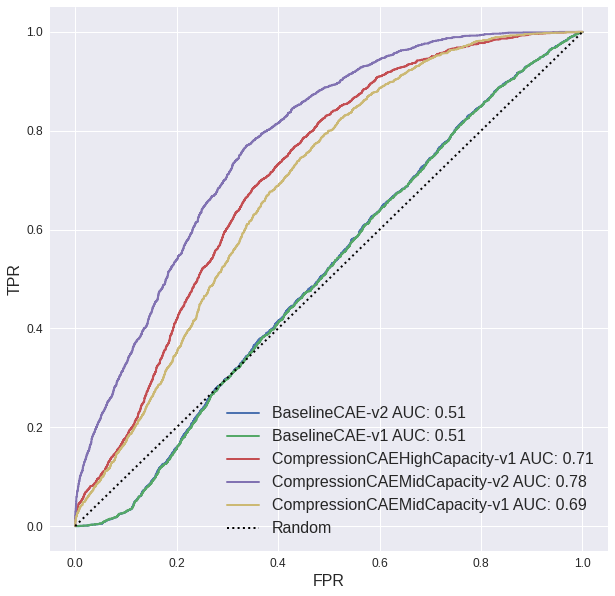

Random ROC AUC: 0.5


In [21]:
logging.getLogger().disabled = True
plt.figure(figsize=(10,10))
for col in scores:
    fpr, tpr, thresholds = metrics.roc_curve(labels[col], scores[col])
    roc_auc_score = metrics.roc_auc_score(labels[col], scores[col])

    plt.plot(fpr, tpr, lw=2., label=f'{col} AUC: {roc_auc_score:.2f}')

    print(f'{col} ROC AUC: {roc_auc_score}')
    
plt.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random')
plt.legend(fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.show()
print('Random ROC AUC: 0.5')

In [7]:
print(len(test_novelty_labels))
print(len(test_novelty_scores))
print(np.unique(test_novelty_labels, return_counts=True))

9984
9984
(array([0, 1]), array([7986, 1998]))
